In [1]:
import json
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
%matplotlib inline

In [21]:
blue = '#264653'
green = '#2a9d8f'
yellow = '#e9c46a'
orange = '#f4a261'
red = '#e76f51'
black = '#50514F'

In [2]:
# read roads in Ghent
streets = gpd.read_file('Data/ex_SXXm38nTMVKwsPsrBjWKF5Q6ch5zi_osm_line.geojson')

In [35]:
sum(streets.bicycle == 'yes')

911

0

In [3]:
# keep only the larger parts
streets = streets.loc[streets.length > 1e-3]
n_streets = len(streets)
length_streets = streets.length

In [4]:
streets.head()

access aerialway aeroway amenity  area barrier bicycle boundary brand  \
1   None      None    None    None  None    None     yes     None  None   
4   None      None    None    None  None    None     yes     None  None   
5   None      None    None    None  None    None    None     None  None   
7   None      None    None    None  None    None    None     None  None   
8   None      None    None    None  None    None     yes     None  None   

  bridge   ...   tower:type tracktype tunnel water waterway way_area wetland  \
1   None   ...         None      None   None  None     None     None    None   
4   None   ...         None      None   None  None     None     None    None   
5   None   ...         None      None   None  None     None     None    None   
7   None   ...         None      None   None  None     None     None    None   
8   None   ...         None      None   None  None     None     None    None   

  width  wood z_order  
1  None  None    33.0  
4  None  None    33.0  
5  None  None     0.0  
7  None  None     0.0  
8  None  None    33.0  

[5 rows x 59 columns]

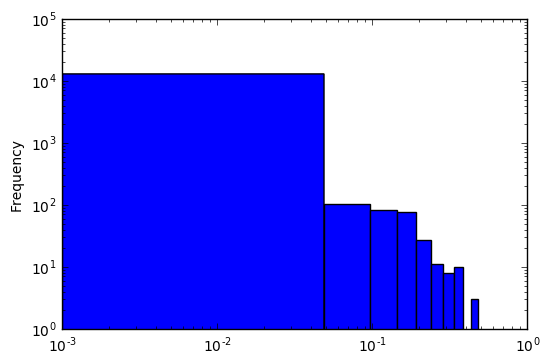

In [5]:
streets.length.plot(kind='hist', logx=True, logy=True)

In [7]:
# get all parks
polygons = gpd.read_file('Data/ex_SXXm38nTMVKwsPsrBjWKF5Q6ch5zi_osm_polygon.geojson')
parks = polygons.loc[polygons.leisure=='park']
parks = parks.loc[parks.geometry.area > 1e-5]  # only parks larger than 100 m^2

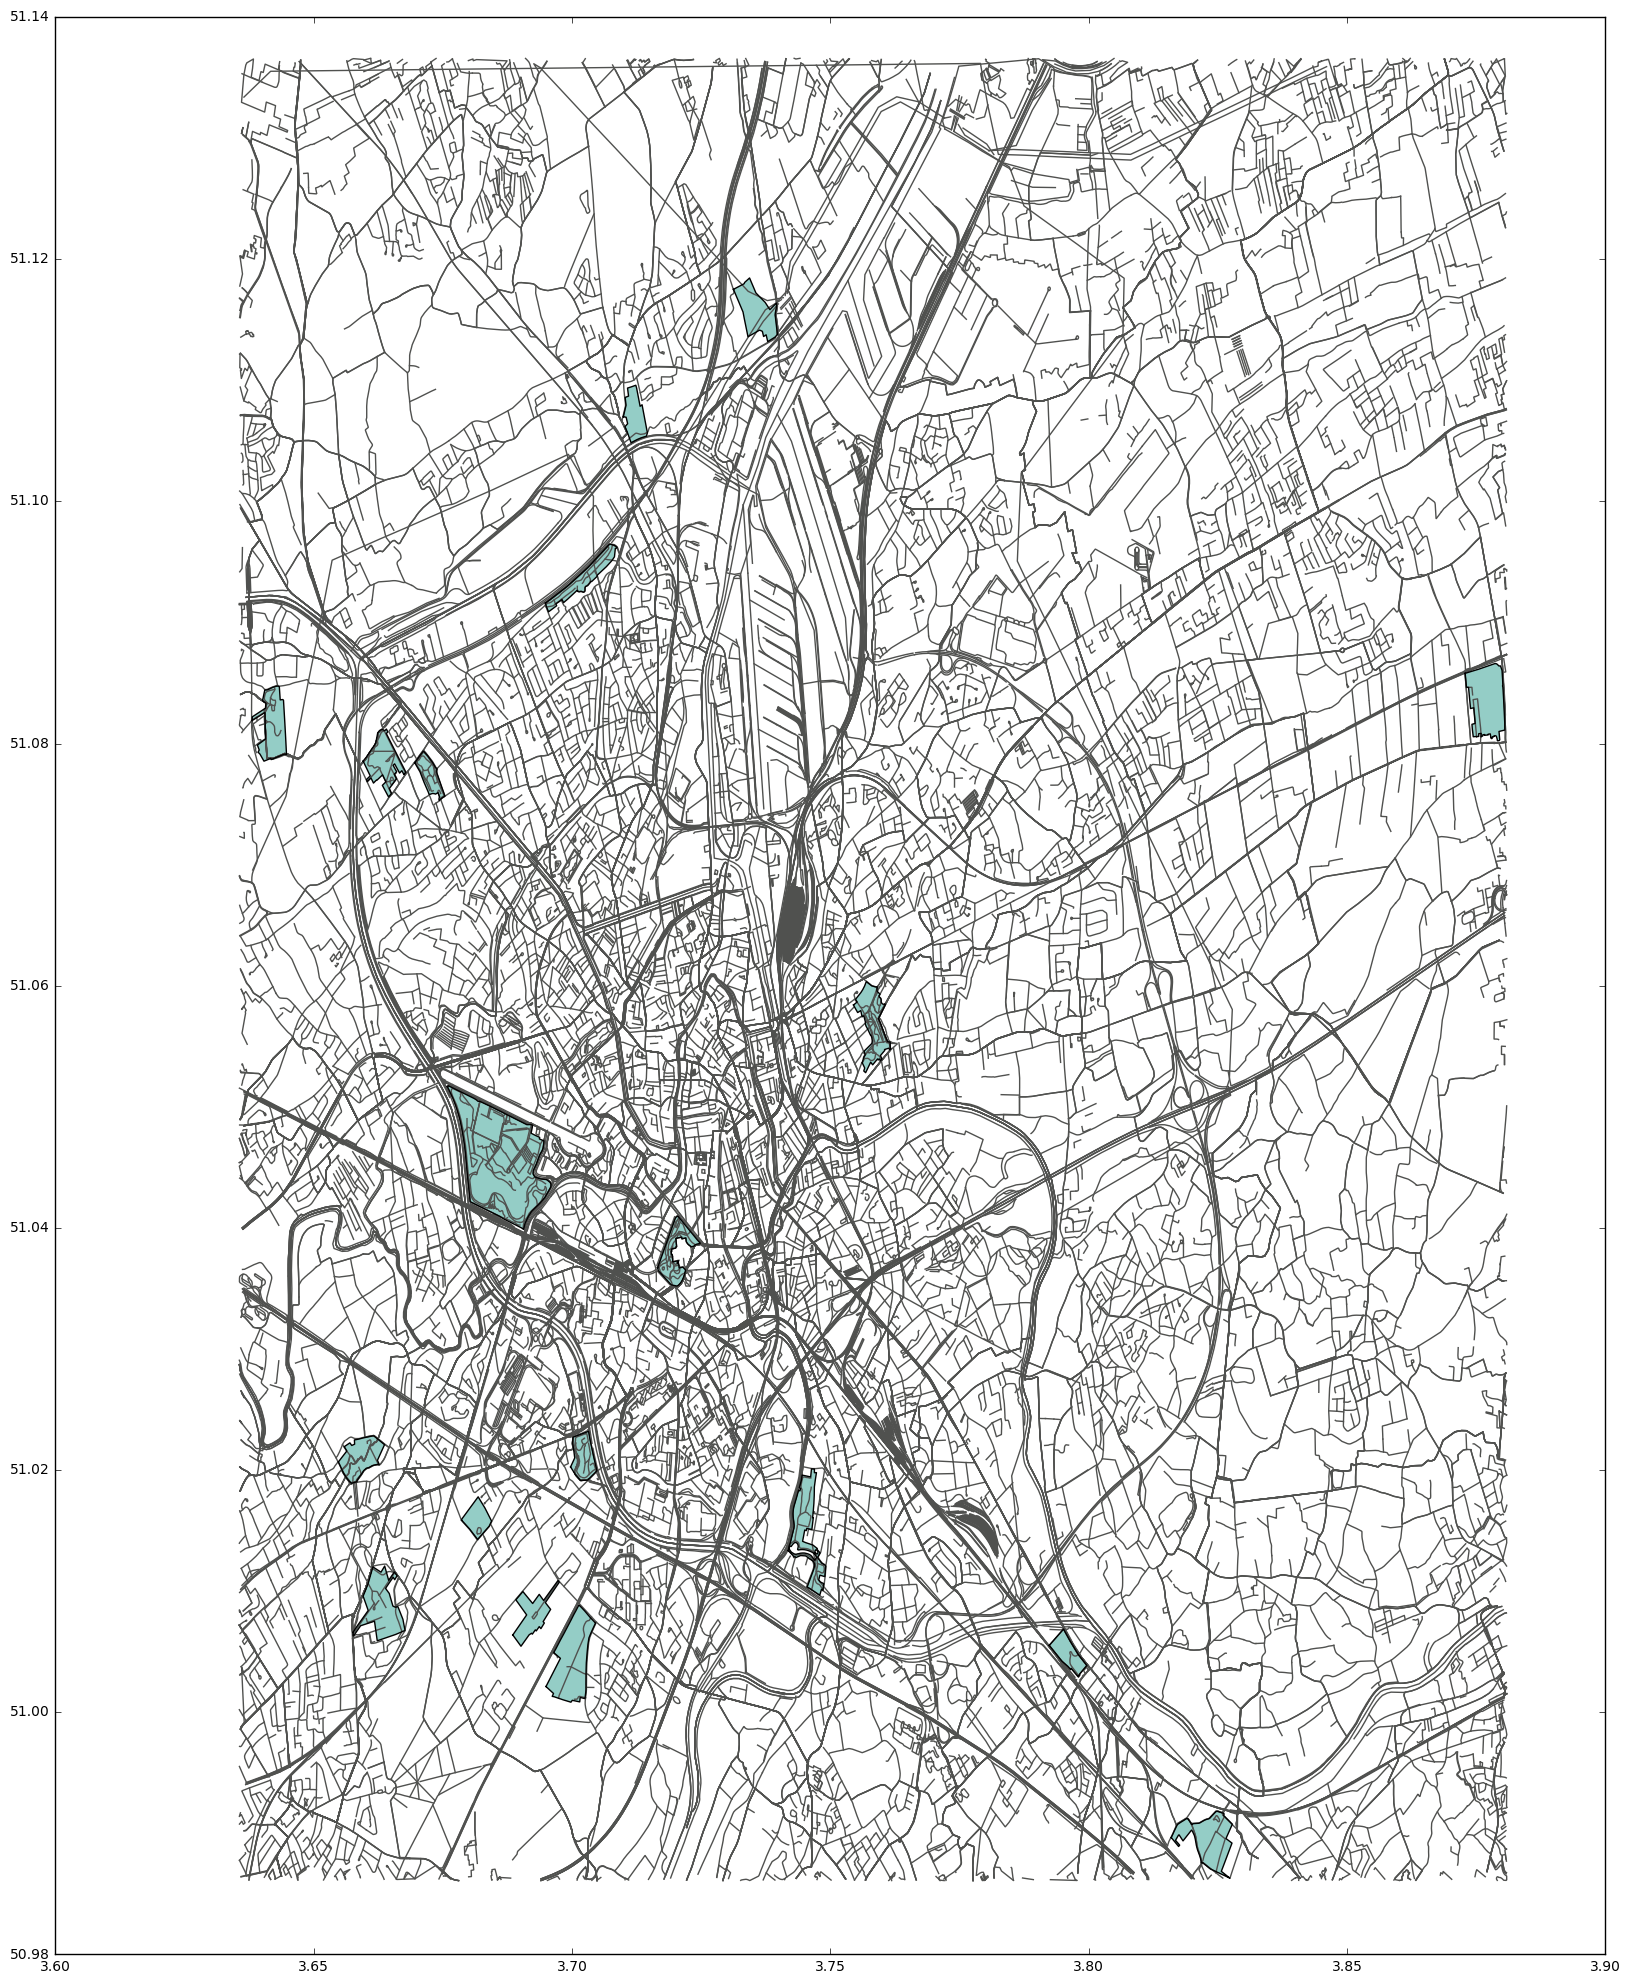

In [89]:
fig, ax = plt.subplots(figsize=(20, 25))
streets.plot(color=black, ax=ax)
parks.plot(color=green, zorder=3, ax=ax)

In [9]:
coordinates = []

for i in range(len(streets)):
    x, y = streets.iloc[i].geometry.coords.xy
    x0, xe = x[0], x[-1]
    y0, ye = y[0], y[-1]
    v0, v1 = [x0, y0], [xe, ye]
    coordinates += [[x0, y0], [xe, ye]]

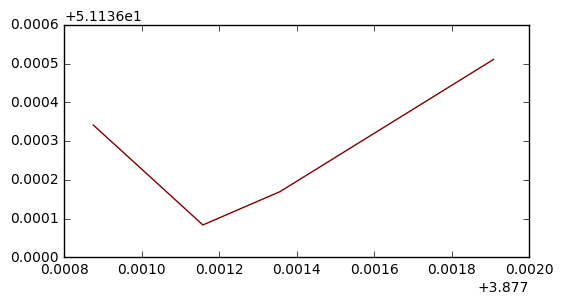

In [94]:
streets.iloc[i:i+1].plot()

In [95]:
streets.iloc[i].geometry.coords.xy

(array('d', [3.8778749, 3.8780151, 3.8781576, 3.8783565, 3.8789077]),
 array('d', [51.1363412, 51.1362134, 51.1360834, 51.1361693, 51.1365106]))

In [10]:
kdtree = KDTree(coordinates)

In [82]:
tol = 1e-4

points = set([])

for coor in coordinates:
    points.add(tuple(kdtree.query_radius([coor], r=tol)[0].tolist()))

In [83]:
unique_coordinates = [coordinates[point[0]] for point in points]

kdtree_unique = KDTree(unique_coordinates)

vertices = set(range(len(unique_coordinates)))
edges = []
vertex_coordinates = {i : tuple(coord) for i, coord in enumerate(unique_coordinates)}
vertices_in_park = set([])

for i in range(len(streets)):
    x, y = streets.iloc[i].geometry.coords.xy
    x0, xe = x[0], x[-1]
    y0, ye = y[0], y[-1]
    w = float(length_streets.iloc[i])
    u = kdtree_unique.query([[x0, y0]], return_distance=False)[0,0]
    v = kdtree_unique.query([[xe, ye]], return_distance=False)[0,0]
    edges.append((w, u, v))
    if np.any(parks.contains(shapely.geometry.asPoint([x0, y0]))):
        vertices_in_park.add(u)
    if np.any(parks.contains(shapely.geometry.asPoint([xe, ye]))):
        vertices_in_park.add(v)

In [84]:
graph = {i : [] for i in vertices}

for w, u, v in edges:
    graph[u].append((w, v))
    graph[v].append((w, u))

In [85]:
to_check = []
components = []
vertices_not_checked = set(graph.keys())
while vertices_not_checked:
    component = set([])
    to_check.append(vertices_not_checked.pop())
    while to_check:
        u = to_check.pop()
        vertices_not_checked.discard(u)
        for _, v in graph[u]:
            if v not in component:
                component.add(v)
                to_check.append(v)
    components.append(component)
    
largest_component = max(components, key=len)

In [86]:
for u in list(graph.keys()):
    if u not in largest_component:
        del graph[u]

In [87]:
edges = []
for u in graph.keys():
    for w, v in graph[u]:
        edges += [(w, u, v)]

(50.986098900000002, 51.136584300000003)

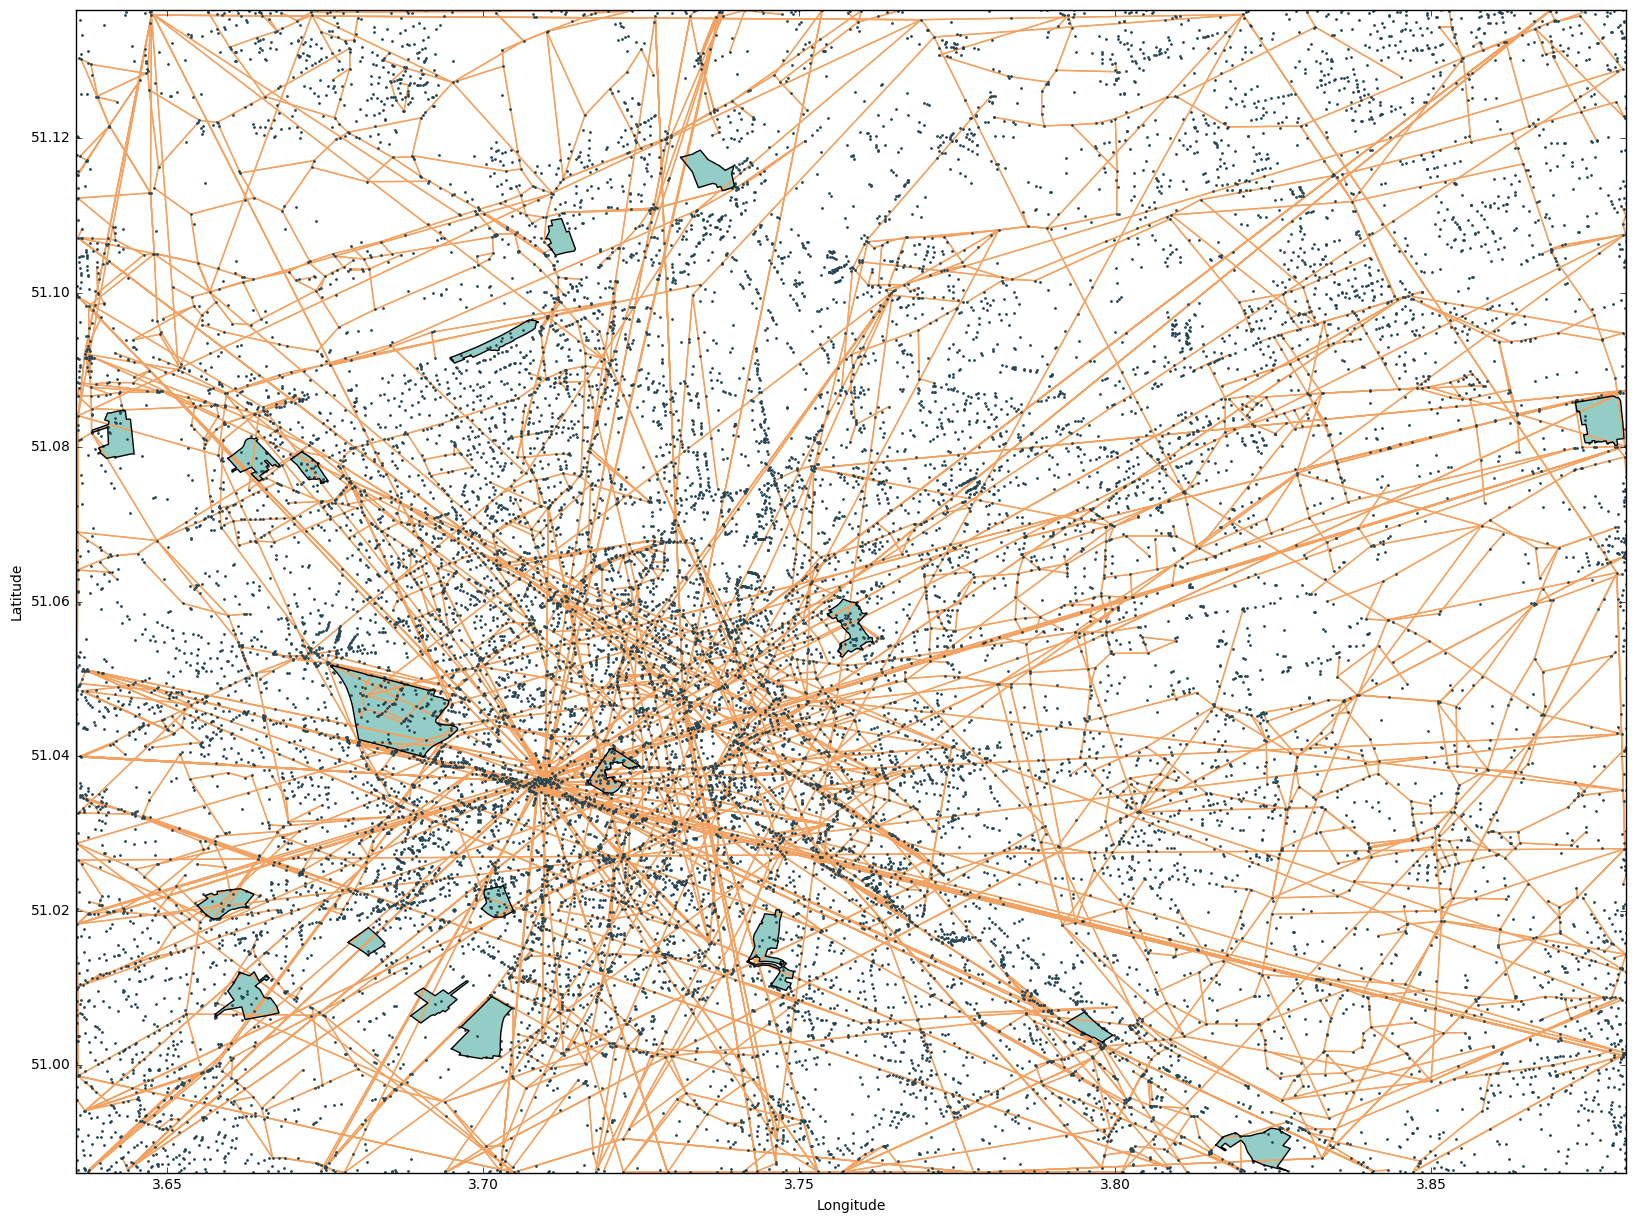

In [88]:
fig, ax = plt.subplots(figsize=(20, 15))

xmin, ymin = np.array(coordinates).min(0)
xmax, ymax = np.array(coordinates).max(0)

ax.scatter(*zip(*unique_coordinates), s=1,zorder=2, color=blue)
for w, u, v in edges:
    x1, y1 = vertex_coordinates[u]
    x2, y2 = vertex_coordinates[v]
    ax.plot([x1, x2], [y1, y2], zorder=1, color=orange)

parks.plot(ax=ax, color=green, zorder=3)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

In [38]:
# make graph
edges = set([])
vertices_park = set([])
vertices = set([])

for i in range(len(streets)):
    x, y = streets.iloc[i].geometry.coords.xy
    x0, xe = x[0], x[-1]
    y0, ye = y[0], y[-1]
    v0, v1 = (x0, y0), (xe, ye)
    length = float(length_streets.iloc[i])
    edges.add((length, v0, v1))
    vertices.add(v0)
    vertices.add(v1)
    if np.any(parks.contains(shapely.geometry.asPoint(v0))):
        vertices_park.add(v0)
    if np.any(parks.contains(shapely.geometry.asPoint(v1))):
        vertices_park.add(v1)

In [22]:
c = 0
for s in streets.
    c+=1


In [23]:
c

59

In [28]:
len(edges)

1119